In [219]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import spearmanr

In [151]:
datadir = Path("D:/Austin/IPI/export/")
archetype_txt = Path("D:/Austin/IPI/archetypes.csv")

archetype_df = pd.read_csv(archetype_txt)


In [152]:
arch_dict = {}
arch_dict['Sample'] = []
arch_dict['Archetype'] = []

for row in archetype_df.iterrows():
    arch_dict['Sample'].append(row[1]['Sample'].split(".")[0])
    try:
        if np.isnan(row[1]['Archetype']):
            arch_dict['Archetype'].append('None')
    except TypeError:    
        arch_dict['Archetype'].append(row[1]['Archetype'])
arch_df = pd.DataFrame(data=arch_dict)
arch_df.set_index("Sample")

,Archetype
Sample,
IPICRC076,Immune_Desert_CD4_Macro_Bias
IPIGYN019,Immune_Desert_CD4_Macro_Bias
IPIGYN019,Immune_Desert_CD4_Macro_Bias
IPIGYN019,Immune_Desert_CD4_Macro_Bias
IPIGYN043,Immune_Desert_CD4_Macro_Bias
...,...
IPIGYN007,None
IPIHEP012,None
IPIKID090,None


In [153]:
flow_data_raw = pd.read_csv("D:/Austin/IPI/IPI_Flow_Data_Lymphocytes.csv")
flow_data_raw['flow_frac_cd4'] = flow_data_raw["%CD4/all cells"]/100
flow_data_raw['flow_frac_cd8'] = flow_data_raw["%CD8/all cells"]/100
flow_data_raw.rename(columns={'Sample ID':'Sample'}, inplace=True)
flow_data = flow_data_raw[['Sample', 'flow_frac_cd4', 'flow_frac_cd8']]
flow_data = flow_data.set_index('Sample')

In [154]:
cd4_fraction = {}
cd8_fraction = {}

for file in datadir.glob("*csv"):
    
    fileparts = file.name.split(".")
    sample = fileparts[0]
    
    df = pd.read_csv(file)
    
    cd4_fraction[sample] = np.sum(df['Class']=='cd4_t_cell')/len(df)
    cd8_fraction[sample] = np.sum(df['Class']=='cd8_t_cell')/len(df)

In [155]:
cd4_data_to_merge = {}
cd8_data_to_merge = {}

for k in cd4_fraction:
    if "_" in k:
        try:
            cd4_data_to_merge[k.split("_")[0]].append(cd4_fraction[k])
        except KeyError:
            cd4_data_to_merge[k.split("_")[0]] = [cd4_fraction[k]]
        
        try:
            cd8_data_to_merge[k.split("_")[0]].append(cd8_fraction[k])
        except KeyError:
            cd8_data_to_merge[k.split("_")[0]] = [cd8_fraction[k]]

for k,v in cd4_data_to_merge.items():
    cd4_fraction[k] = np.mean(v)
for k,v in cd8_data_to_merge.items():
    cd8_fraction[k] = np.mean(v)

In [156]:
if_data = {}
if_data['Sample'] = list(cd4_fraction.keys())
if_data['if_frac_cd4'] = list(cd4_fraction.values())
if_data['if_frac_cd8'] = list(cd8_fraction.values())
if_df = pd.DataFrame.from_dict(data = if_data)
if_df = if_df.set_index("Sample")

In [187]:
result = flow_data.merge(if_df, on='Sample')
result = result.merge(arch_df, on='Sample')
result.drop_duplicates(inplace=True)

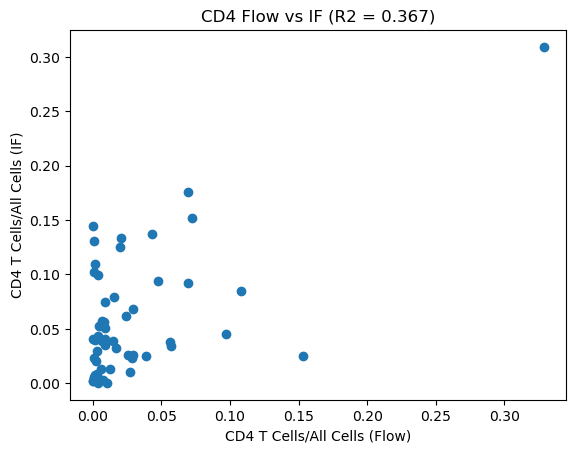

In [188]:
fig = plt.figure()
fig.set_facecolor('white')
plt.scatter(result['flow_frac_cd4'], result['if_frac_cd4'])
plt.xlabel('CD4 T Cells/All Cells (Flow)')
plt.ylabel('CD4 T Cells/All Cells (IF)')
corr = str(spearmanr(result['flow_frac_cd4'].values, result['if_frac_cd4'].values).correlation)
plt.title(f'CD4 Flow vs IF (R2 = {corr[0:5]})')

plt.savefig(Path("D:/Austin/IPI/analysis/" + "CD4_flow_IF.png"), transparent=False, bbox_inches='tight')

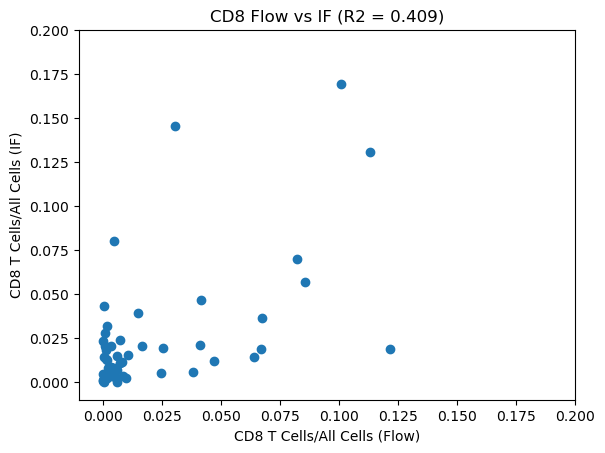

In [190]:
fig = plt.figure()
fig.set_facecolor('white')
plt.scatter(result['flow_frac_cd8'], result['if_frac_cd8'])
plt.xlabel('CD8 T Cells/All Cells (Flow)')
plt.ylabel('CD8 T Cells/All Cells (IF)')
corr = str(spearmanr(result['flow_frac_cd8'].values, result['if_frac_cd8'].values).correlation)
plt.title(f'CD8 Flow vs IF (R2 = {corr[0:5]})')
plt.xlim([-0.01,0.2])
plt.ylim([-0.01,0.2])
plt.savefig(Path("D:/Austin/IPI/analysis/" + "CD8_flow_IF.png"), transparent=False, bbox_inches='tight')

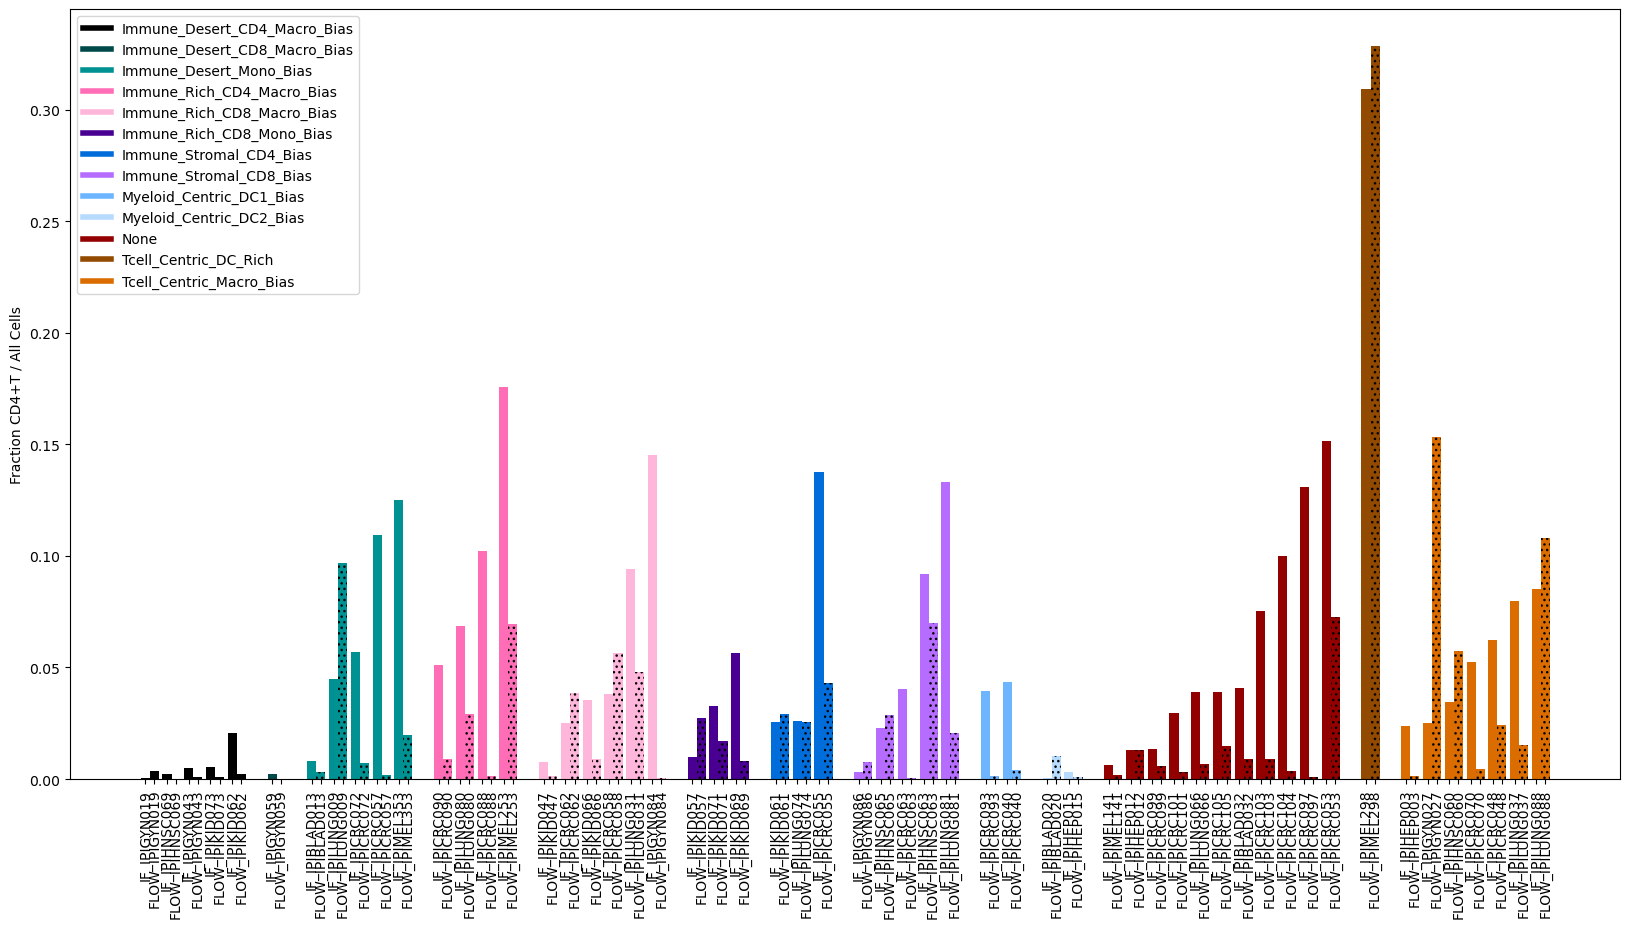

In [222]:
archetypes = np.unique(result['Archetype'])

colors=["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

fig = plt.figure(figsize=(20,10))
fig.set_facecolor("white")

x=0
w = 0.25
gap = 0.1
arch_gap = 0.5
xtick_pos = []
xtick_labels = []

legend_lines = []
legend_labels = []

for i, arch in enumerate(archetypes):
    c = colors[i]
    
    data = result[result['Archetype']==arch]
    data.sort_values(by='if_frac_cd4', inplace=True)
    
    for row in data.iterrows():
        
        plt.bar(x,row[1]['if_frac_cd4'],width=w,color=c)
        xtick_pos.append(x)
        xtick_labels.append("IF_"+row[1]['Sample'])
        x+=w
        plt.bar(x,row[1]['flow_frac_cd4'],width=w,hatch='...',color=c)
        xtick_pos.append(x)
        xtick_labels.append("FLOW_"+row[1]['Sample'])
        x+=w+gap
        
        
    x+=arch_gap
    
    legend_lines.append(Line2D([0], [0], color=c, lw=4))
    legend_labels.append(arch)
    
plt.xticks(xtick_pos, xtick_labels,rotation=90)
plt.ylabel("Fraction CD4+T / All Cells")
plt.legend(legend_lines, legend_labels)
plt.savefig(Path("D:/Austin/IPI/analysis/CD4_if_vs_flow_by_sample.png"), transparent=False, bbox_inches='tight')

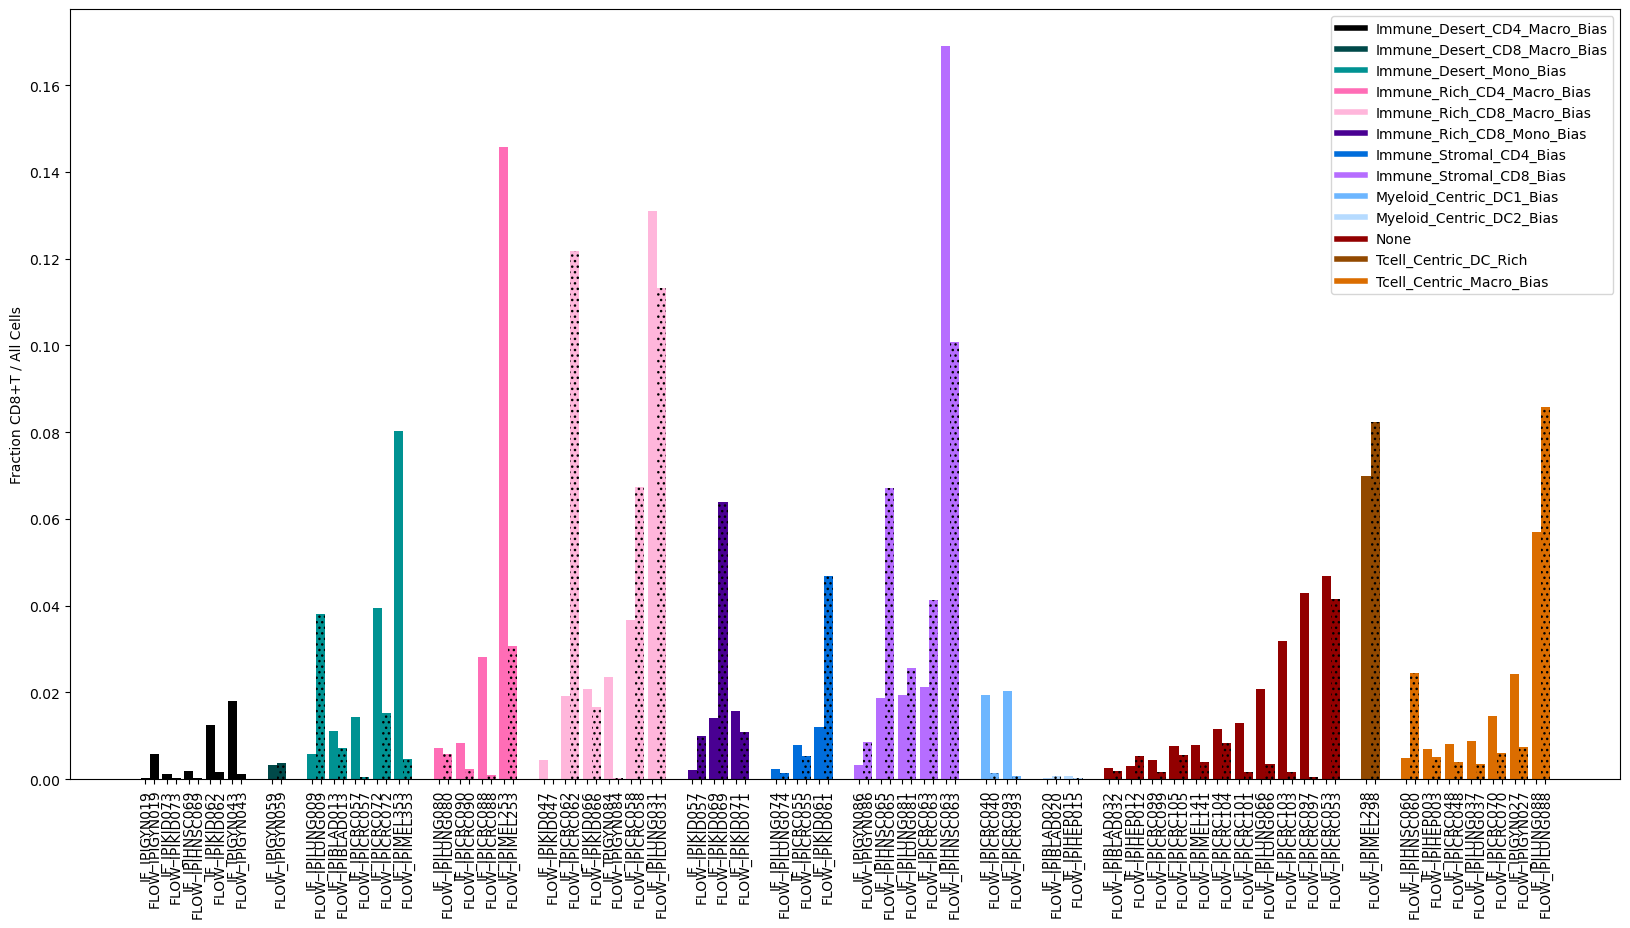

In [223]:
archetypes = np.unique(result['Archetype'])

colors=["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

fig = plt.figure(figsize=(20,10))
fig.set_facecolor("white")

x=0
w = 0.25
gap = 0.1
arch_gap = 0.5
xtick_pos = []
xtick_labels = []

legend_lines = []
legend_labels = []

for i, arch in enumerate(archetypes):
    c = colors[i]
    
    data = result[result['Archetype']==arch]
    data.sort_values(by='if_frac_cd8', inplace=True)
    
    for row in data.iterrows():
        
        plt.bar(x,row[1]['if_frac_cd8'],width=w,color=c)
        xtick_pos.append(x)
        xtick_labels.append("IF_"+row[1]['Sample'])
        x+=w
        plt.bar(x,row[1]['flow_frac_cd8'],width=w,hatch='...',color=c)
        xtick_pos.append(x)
        xtick_labels.append("FLOW_"+row[1]['Sample'])
        x+=w+gap
        
        
    x+=arch_gap
    
    legend_lines.append(Line2D([0], [0], color=c, lw=4))
    legend_labels.append(arch)
    
plt.xticks(xtick_pos, xtick_labels,rotation=90)
plt.ylabel("Fraction CD8+T / All Cells")
plt.legend(legend_lines, legend_labels)
plt.savefig(Path("D:/Austin/IPI/analysis/cd8_if_vs_flow_by_sample.png"), transparent=False, bbox_inches='tight')